<a href="https://colab.research.google.com/github/vThedDatadev/ia/blob/main/imageto3dd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [DreamGaussian](https://github.com/dreamgaussian/dreamgaussian) image-to-3D demo

In [1]:
#@title install (only run once)
%rm -r dreamgaussian
!git clone https://github.com/dreamgaussian/dreamgaussian
%cd dreamgaussian

# install dependencies
!pip install -q einops plyfile dearpygui huggingface_hub diffusers accelerate transformers xatlas trimesh PyMCubes pymeshlab rembg[gpu,cli] omegaconf ninja

# build extension from source (can be slow)
# !git clone --recursive https://github.com/ashawkey/diff-gaussian-rasterization
# !pip install -q ./diff-gaussian-rasterization
# !pip install -q ./simple-knn

# pre-built wheels (faster)
!pip install -q https://github.com/camenduru/diff-gaussian-rasterization/releases/download/v1.0/diff_gaussian_rasterization-0.0.0-cp310-cp310-linux_x86_64.1.whl
!pip install -q https://github.com/camenduru/diff-gaussian-rasterization/releases/download/v1.0/simple_knn-0.0.0-cp310-cp310-linux_x86_64.1.whl

# nvdiffrast
!pip install -q git+https://github.com/NVlabs/nvdiffrast

# kiuikit
!pip install -q git+https://github.com/ashawkey/kiuikit

%mkdir -p data

rm: cannot remove 'dreamgaussian': No such file or directory
Cloning into 'dreamgaussian'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 229 (delta 113), reused 74 (delta 62), pack-reused 67
Receiving objects: 100% (229/229), 1.47 MiB | 19.10 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/dreamgaussian
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 308.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.4/229.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.0/690.0 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.3/274.3 kB 29.0 MB/s eta 0:00:00


/content/dreamgaussian/data


Saving name.png to name.png
/content/dreamgaussian


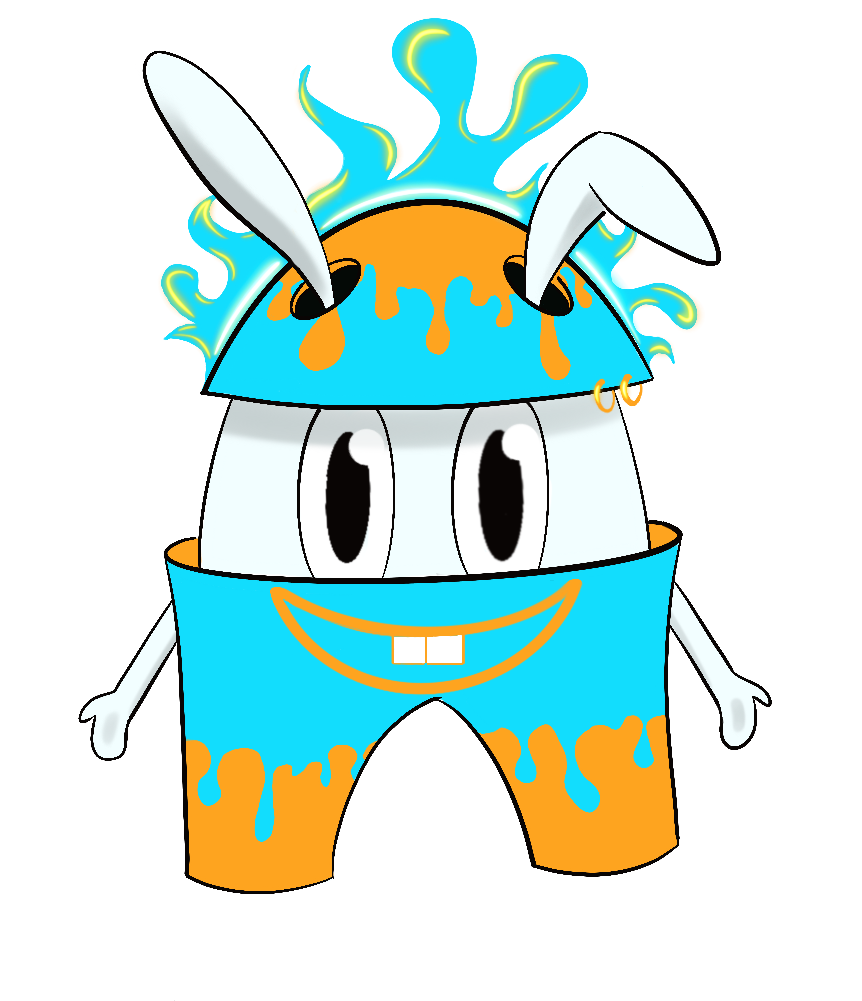

In [2]:
#@title upload image

import os
os.environ['TF_ENABLE_MLIR_OPTIMIZATIONS'] = '1'
%cd data/
%rm * # remove all old files!
from google.colab import files
uploaded = files.upload()
IMAGE = os.path.basename(next(iter(uploaded))) # filename
%cd ..

# display image
from IPython.display import Image, display
display(Image(f'data/{IMAGE}', width=256, height=256))

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 162GB/s]


[INFO] loading image data/name.png...
[INFO] background removal...
[INFO] recenter...


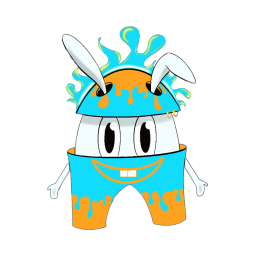

In [3]:
#@title preprocess image

# preprocess
%run process.py data/{IMAGE}

NAME = os.path.splitext(IMAGE)[0]
IMAGE_PROCESSED = NAME + '_rgba.png'

# display processed image
from IPython.display import Image, display
display(Image(f'data/{IMAGE_PROCESSED}', width=256, height=256))

# Settings
* Elevation: estimated elevation angle, default to 0 (horizontal), range from [-90, 90]. If you upload a look-down image, try a value like -30.

In [ ]:
#@markdown ####**Settings:**
Elevation = 1 #@param {type: 'integer'}

In [6]:
#@title training!
!pip install xformers==v0.0.22
!pip install -r cam_utils
!import os
#%os.environ['TF_ENABLE_MLIR_OPTIMIZATIONS'] = '1'

# stage 1
%run main.py --config configs/image.yaml input=data/{IMAGE_PROCESSED} save_path={NAME} elevation={Elevation} force_cuda_rast=True

# stage 2
%run main2.py --config configs/image.yaml input=data/{IMAGE_PROCESSED} save_path={NAME} elevation={Elevation} force_cuda_rast=True

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'cam_utils'
/bin/bash: line 1: import: command not found


Exception: File `'main.py'` not found.

In [ ]:
#@title render a video for displaying

# the final mesh is saved to ./logs/NAME.obj
%run -m kiui.render logs/{NAME}.obj --save_video {NAME}.mp4 --wogui --force_cuda_rast

from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width=450):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video(f'{NAME}.mp4')

FileNotFoundError: [Errno 2] No such file or directory: 'logs/GGJ_Perso_2.obj'

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:2940: UserWarning: Unknown failure executing module: <kiui.render>
  warn('Unknown failure executing module: <%s>' % mod_name)


FileNotFoundError: [Errno 2] No such file or directory: 'GGJ_Perso_2.mp4'